# Import of needed packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyQME.spectral_density import SpectralDensity
from pyQME.tensors import RedfieldTensorReal,ForsterTensor,ModifiedRedfieldTensor

from pyQME.utils import wn2ips

# Compare EET rates with Forster, Redfield, modified Redfield

This comparison is based on the following reference:
> Cupellini *et al.*, *WIREs Comput. Mol. Sci.* (2019), **9**, e1392, [DOI:10.1002/wcms.1392](http://dx.doi.org/10.1002/wcms.1392)

We will reproduce part of Figure 6 in the paper (the solid lines in each panel).

## Define the spectral density

We are going to use the B777 spectral density (Renger & Marcus, *J Chem Phys.* (2002), **116** 9997–10019.) 

In the following definition, the reorganization energy is ~78 cm$^{-1}$ when the scale factor is one.

In [2]:
def get_B777(scale=1.0,S1=0.8,S2=0.5,W1=0.5565,W2=1.936,wmax=3000):
    "Computes B777 type spectral density"

    w = np.arange(0.02,wmax+0.02,0.02)

    fact7 = 7*6*5*4*3*2


    prefact = scale/(S1+S2)
    fact1 = (S1*w**3)/(fact7*2*W1**4)*np.exp(-np.sqrt((w/W1)))
    fact2 = (S2*w**3)/(fact7*2*W2**4)*np.exp(-np.sqrt((w/W2)))

    J = np.pi*(w**2)*prefact*(fact1+fact2)

    return w,J

In [3]:
freq_axis,specden = get_B777()

SD = SpectralDensity(freq_axis,specden,temperature=300)
SD.time = np.linspace(0.,0.6,25000)
SD.get_gt();
print('Reorg: {:7.1f} cm^-1'.format(SD.Reorg[0]))

Reorg:    78.3 cm^-1


Plot the temperature-dependent spectral density satisfying detailed balance

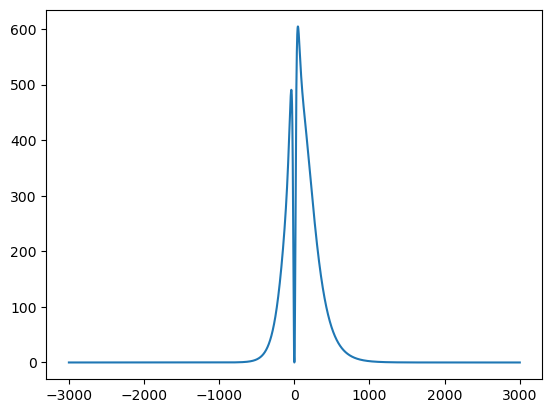

In [4]:
plt.plot(SD.omega,SD.ThermalSD_real[0]);

## Model Hamiltonian and EET calculations

Here we define a 2-state Hamiltonian for a Donor-Acceptor system and compute the EET rates with different theories

In [5]:
H = np.asarray([[10000,100],[100,10100]]) # D-A system

### Calculate the downhill EET rates with the various methods

In [6]:
forst = ForsterTensor(H,SD)

rate = forst.get_rates()[0,1]*wn2ips
time = 1/rate
print('Rate: {:6.2f} ps^-1   tau = {:6.2f} ps '.format(rate,time))

Rate:  19.33 ps^-1   tau =   0.05 ps 


In [7]:
mR = ModifiedRedfieldTensor(H,SD)

rate = mR.get_rates()[0,1]*wn2ips
time = 1/rate
print('Rate: {:6.2f} ps^-1   tau = {:6.2f} ps '.format(rate,time))

Rate:  35.14 ps^-1   tau =   0.03 ps 


In [8]:
Redf = RedfieldTensorReal(H,SD)

# Why this does not work?
##  rate = Redf.rates[0,1]*wn2ips
rate = Redf.get_rates()[0,1]*wn2ips
time = 1/rate
print('Rate: {:6.2f} ps^-1   tau = {:6.2f} ps '.format(rate,time))

Rate:  24.02 ps^-1   tau =   0.04 ps 


## Compare rates as a function of the reorganization energy

We will reproduce part of Figure 6d in the WIREs paper.




In [9]:
reorg_scan = np.logspace(1,3,100) # from 10 to 1000     #to be saved

delta_E = 100.0
coup = 40.0

# Create Hamiltonian (which now is constant)
Ham = np.asarray([[10000,coup],[coup,10000+delta_E]])

k_Forster     = []
k_modRedfield = []
k_Redfield    = []
# Loop over the reorganization energy values
for reorg in reorg_scan:
    
    scale = reorg/SD.Reorg # calculate scale factor
    
    freq_axis,specden = get_B777(scale=scale)   

    SD_i = SpectralDensity(freq_axis,specden,temperature=300)
    SD_i.time = np.linspace(0.,0.6,25000)
    SD_i.get_gt();
    #print('Reorg: {:7.1f} cm^-1'.format(SD_i.Reorg[0]))
    
    # Do Forster calculation
    forst = ForsterTensor(Ham,SD_i)
    rate = forst.get_rates()[0,1]*wn2ips
    # Append rate to list
    k_Forster.append(rate)
    
    # Do Modified Redfield
    mR = ModifiedRedfieldTensor(Ham,SD_i)
    rate = mR.get_rates()[0,1]*wn2ips
    k_modRedfield.append(rate)
    
    # Do Redfield
    Red = RedfieldTensorReal(Ham,SD_i)
    rate = Red.get_rates()[0,1]*wn2ips
    k_Redfield.append(rate)
    
# Transform lists into arrays
k_Forster = np.asarray(k_Forster)     #to be saved
k_modRedfield = np.asarray(k_modRedfield)     #to be saved
k_Redfield = np.asarray(k_Redfield)     #to be saved

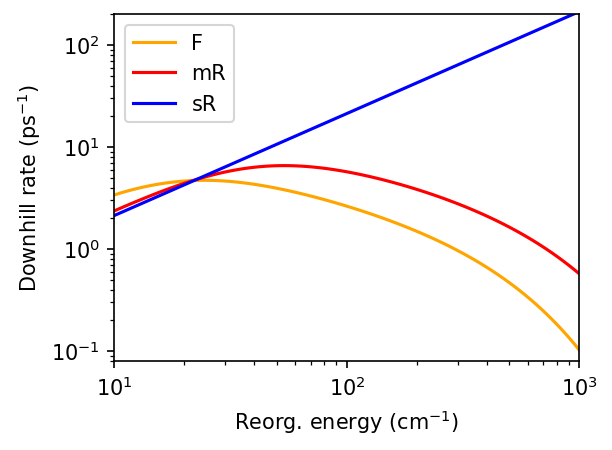

In [10]:
fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=150)

plt.plot(reorg_scan,k_Forster,color='orange',label='F')
plt.plot(reorg_scan,k_modRedfield,color='r',label='mR')
plt.plot(reorg_scan,k_Redfield,color='b',label='sR')
plt.legend()

plt.xscale('log')
plt.xlim(10,1000)

plt.yscale('log')
plt.ylim(8e-2,2e2)

plt.xlabel('Reorg. energy (cm$^{-1}$)')
plt.ylabel('Downhill rate (ps$^{-1}$)')

plt.minorticks_on()